In [1]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import xarray as xr
from math import ceil,sin,cos, atan2, pi, sqrt
import matplotlib
from matplotlib import pyplot as plt, animation, rc,colors
from datetime import datetime, timedelta
#from cartopy import crs, feature
#import cmocean
import yaml

from IPython.display import Image
rc('animation', html='html5')

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions import *

In [2]:
N = '/home/jvalenti/MOAD/analysis-jose/OParcels/Deploy_locations.csv'
MFc= 1e6
dtp= 10

In [3]:
def pandas_deploy(N,MFc,dtp):
    MFc = float(MFc)
    Rivers_deploy = pd.read_csv(N, index_col = [0])
    Pol = list(Rivers_deploy.Population_polluting)
    Lat = Rivers_deploy.Latitude
    Lon = Rivers_deploy.Longitude
    clat = []
    clon = []
    for i,loc in enumerate(Pol):
        for j in range(int(round((loc*25*dtp)/MFc,0))):
            clat.append(Lat.iat[i])
            clon.append(Lon.iat[i])
    return len(clat)  

In [4]:
path_bat = '/home/jvalenti/MOAD/grid/bathymetry_202108.nc'
bat = xr.open_dataset(path_bat,decode_times=False).Bathymetry

In [5]:
path_d='/results2/SalishSea/nowcast-green.202111/30oct22/SalishSea_1h_20221030_20221030_grid_T.nc'
path_d2='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_T.nc'
path_area='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_T.nc'
path_w='/results2/SalishSea/nowcast-green.202111/30oct22/SalishSea_1h_20221030_20221030_grid_W.nc'
path_w2='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_W.nc'
path_u='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_U.nc'
path_v='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_V.nc'

path_mask = '/ocean/jvalenti/MOAD/grid2/mesh_mask202108_TD.nc'
e3t = xr.open_dataset(path_d,decode_times=False).e3t
e3t2 = xr.open_dataset(path_d2,decode_times=False).e3t
e3t = xr.concat([e3t,e3t2],dim='time_counter')
Area = xr.open_dataset(path_area,decode_times=False).area
mbathy = xr.open_dataset(path_mask,decode_times=False).mbathy
zz_ww = xr.open_dataset(path_mask,decode_times=False).gdepw_0
e3t0 = xr.open_dataset(path_mask,decode_times=False).e3t_0

In [6]:
ssh = xr.open_dataset(path_d,decode_times=False).sossheig[:,300,297:302]
ssh2 = xr.open_dataset(path_d2,decode_times=False).sossheig[:,300,297:302]
ssh = xr.concat([ssh,ssh2],dim='time_counter')
mbathy = xr.open_dataset(path_mask,decode_times=False).mbathy[0,300,297:302]
u = xr.open_dataset(path_u,decode_times=False).vozocrtx[:,:,300,297:302]
w = xr.open_dataset(path_w,decode_times=False).vovecrtz[:,:,300,297:302]
w2 = xr.open_dataset(path_w2,decode_times=False).vovecrtz[:,:,300,297:302]
w = xr.concat([w,w2],dim='time_counter')
depthw = xr.open_dataset(path_w,decode_times=False).depthw
depthu = xr.open_dataset(path_u,decode_times=False).depthu
totaldepth = zz_ww[0, mbathy,300, 297:302]

In [7]:
#Define domain
lon = np.array([250.,750., 1250.,1750.,2250.])
#lonu = np.array([500.,1000., 1500.,2000.,2500])
#latv = np.array([500.,1000.])
#lat = np.array([250.,750])
time = np.linspace(0,2*86400,48)

dim = 5
dep = len(depthu)
t = len(time)

#U = Field('U', u, dtype=np.float32)
#U = Field('U', u, lon=lonu, lat=None, depth=depthu, time=time)
U = Field('U', np.zeros((dep, dim), dtype=np.float32), lon=lon, lat=None, depth=depthu)
V = Field('V', np.zeros((dep, dim), dtype=np.float32), lon=lon, lat=None, depth=depthu)
W = Field('W', w, lon=lon, lat=None, depth=depthw, time=time)
SSH = Field('SSH', ssh, lon=lon, lat=None, depth=None, time=time)
Td = Field('TD', totaldepth, lon=lon, lat=None, depth=None, time=None)

In [8]:
#Define domain
lon = np.array([250.,750., 1250.,1750.,2250.])
#lonu = np.array([500.,1000., 1500.,2000.,2500])
#latv = np.array([500.,1000.])
#lat = np.array([250.,750])
time = np.linspace(0,2*86400,48)

dim = 5
dep = len(depthu)
t = len(time)

#U = Field('U', u, dtype=np.float32)
#U = Field('U', u, lon=lonu, lat=None, depth=depthu, time=time)
U = Field('U', np.zeros((dep, dim), dtype=np.float32), lon=lon, lat=None, depth=depthu)
V = Field('V', np.zeros((dep, dim), dtype=np.float32), lon=lon, lat=None, depth=depthu)
W = Field('W', w, lon=lon, lat=None, depth=depthw, time=time)
SSH = Field('SSH', ssh, lon=lon, lat=None, depth=None, time=time)
Td = Field('TD', totaldepth, lon=lon, lat=None, depth=None, time=None)

In [9]:
fieldset = FieldSet(U,V)
fieldset.add_field(W)
fieldset.add_field(SSH)
fieldset.add_field(Td)

In [10]:
class MPParticle(JITParticle):
    fact = Variable('fact', initial =  1.0) 

In [11]:
def DeleteParticle(particle, fieldset, time):
    """Delete particle from OceanParcels simulation to avoid run failure
    """
    
    print(f'Particle {particle.id} lost !! [{particle.time}, {particle.depth}, {particle.lat}, {particle.lon}]')
    particle.delete()

In [12]:
def Advection3(particle, fieldset, time):
    ssh = fieldset.SSH[time, particle.depth, particle.lat, particle.lon]
    td = fieldset.TD[time, particle.depth, particle.lat, particle.lon]
    factor = 1
    particle.fact = factor
    w1 =  fieldset.W[time , particle.depth, particle.lat, particle.lon]
    dep1 = particle.depth + w1*.5*particle.dt
    w2 =  fieldset.W[time + .5 * particle.dt, dep1, particle.lat, particle.lon]
    dep2 = particle.depth + w2*.5*particle.dt
    w3 = fieldset.W[time + .5 * particle.dt, dep2, particle.lat, particle.lon]
    dep3 = particle.depth + w3*particle.dt
    w4 = fieldset.W[time + particle.dt, dep3, particle.lat, particle.lon]
    particle.depth = particle.depth + ((w1 + 2*w2 + 2*w3 + w4) / 6.) * particle.dt

In [13]:
def Advection2(particle, fieldset, time):
    ssh = fieldset.SSH[time, particle.depth, particle.lat, particle.lon]
    sshn = fieldset.SSH[time+particle.dt, particle.depth, particle.lat, particle.lon]
    td = fieldset.TD[time, particle.depth, particle.lat, particle.lon]
    factor = (1+ssh/td)
    particle.fact = factor
    wssh = ((sshn-ssh)*particle.depth/(td))
    w1 =  fieldset.W[time , particle.depth, particle.lat, particle.lon]
    dep1 = particle.depth + w1*.5*particle.dt/factor
    w2 =  fieldset.W[time + .5 * particle.dt, dep1, particle.lat, particle.lon]
    dep2 = particle.depth + w2*.5*particle.dt/factor
    w3 = fieldset.W[time + .5 * particle.dt, dep2, particle.lat, particle.lon]
    dep3 = particle.depth + w3*particle.dt/factor
    w4 = fieldset.W[time + particle.dt, dep3, particle.lat, particle.lon]
    particle.depth = particle.depth + ((w1 + 2*w2 + 2*w3 + w4) / 6.) * particle.dt/factor - wssh

In [14]:
def Advection(particle, fieldset, time):
    ssh = fieldset.SSH[time, particle.depth, particle.lat, particle.lon]
    sshn = fieldset.SSH[time+particle.dt, particle.depth, particle.lat, particle.lon]
    td = fieldset.TD[time, particle.depth, particle.lat, particle.lon]
    factor = (1+ssh/td)
    particle.fact = factor
    wssh = ((sshn-ssh)*particle.depth/(td))
    w1 =  fieldset.W[time , particle.depth, particle.lat, particle.lon]
    dep1 = particle.depth + w1*.5*particle.dt/factor
    w2 =  fieldset.W[time + .5 * particle.dt, dep1, particle.lat, particle.lon]
    dep2 = particle.depth + w2*.5*particle.dt/factor
    w3 = fieldset.W[time + .5 * particle.dt, dep2, particle.lat, particle.lon]
    dep3 = particle.depth + w3*particle.dt/factor
    w4 = fieldset.W[time + particle.dt, dep3, particle.lat, particle.lon]
    particle.depth = particle.depth + ((w1 + 2*w2 + 2*w3 + w4) / 6.) * particle.dt/factor + wssh

In [15]:
n = 1000
KE=Advection
KE2=Advection3
KE3=Advection
lon_g = np.random.uniform(low=250, high=2000, size=(n,))
depth_g = np.random.uniform(low=0.5, high=15, size=(n,))
lat_g = np.ones(n,)*750
pset = ParticleSet(fieldset, pclass=MPParticle, lon=lon_g, depth=depth_g,lat = lat_g)
output_file = pset.ParticleFile(name='/home/jvalenti/MOAD/results/teste7.zarr', outputdt=1000)
pset.execute(KE , runtime=2*86400, dt=90, output_file=output_file,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

pset2 = ParticleSet(fieldset, pclass=MPParticle, lon=lon_g, depth=depth_g,lat = lat_g)
output_file2 = pset2.ParticleFile(name='/home/jvalenti/MOAD/results/teste8.zarr', outputdt=1000)
pset2.execute(KE2 , runtime=2*86400, dt=90, output_file=output_file2,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})
#pset3 = ParticleSet(fieldset, pclass=MPParticle, lon=lon_g, depth=depth_g,lat = lat_g)
#output_file3 = pset3.ParticleFile(name='/home/jvalenti/MOAD/results/test16.zarr', outputdt=1000)
#pset3.execute(KE3 , runtime=2*86400, dt=90, output_file=output_file3,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

INFO: Compiled ArrayMPParticleAdvection ==> /tmp/parcels-2894/lib95ff4cd26ac50f088b32a63408bab89a_0.so
INFO: Output files are stored in /home/jvalenti/MOAD/results/teste7.zarr.
 49%|████▉     | 85000.0/172800.0 [00:00<00:00, 426687.60it/s]

Particle 727 lost !! [100720.0, 9.565217624185607e-06, 750.0, 1334.703369140625]
Particle 580 lost !! [104720.0, 3.483281398075633e-05, 750.0, 1491.305908203125]
Particle 825 lost !! [108450.0, 4.144952981732786e-05, 750.0, 1351.9774169921875]
Particle 273 lost !! [109180.0, 2.310231138835661e-05, 750.0, 1267.628173828125]
Particle 649 lost !! [113180.0, 2.1732594177592546e-05, 750.0, 1738.1689453125]
Particle 30 lost !! [116630.0, 4.8080531996674836e-05, 750.0, 1255.198974609375]
Particle 583 lost !! [117900.0, 2.9051576348138042e-05, 750.0, 1608.1868896484375]
Particle 382 lost !! [118900.0, 2.744967059697956e-05, 750.0, 1302.4921875]


100%|██████████| 172800.0/172800.0 [00:12<00:00, 13380.86it/s]
INFO: Compiled ArrayMPParticleAdvection3 ==> /tmp/parcels-2894/libbc32d33ae3bbe4ba5d9ae50e92b93c12_0.so
INFO: Output files are stored in /home/jvalenti/MOAD/results/teste8.zarr.
 48%|████▊     | 83000.0/172800.0 [00:00<00:00, 780557.83it/s]

Particle 1727 lost !! [100270.0, 4.492321750149131e-05, 750.0, 1334.703369140625]
Particle 1580 lost !! [105000.0, 6.28236448392272e-05, 750.0, 1491.305908203125]
Particle 1273 lost !! [108630.0, 5.1464583521010354e-05, 750.0, 1267.628173828125]
Particle 1825 lost !! [108270.0, 7.092492160154507e-05, 750.0, 1351.9774169921875]
Particle 1030 lost !! [116450.0, 1.2977628102817107e-05, 750.0, 1255.198974609375]
Particle 1382 lost !! [119540.0, 3.435624239500612e-05, 750.0, 1302.4921875]
Particle 1649 lost !! [129900.0, 1.512078711130016e-07, 750.0, 1738.1689453125]
Particle 1583 lost !! [141450.0, 5.04775107401656e-06, 750.0, 1608.1868896484375]


100%|██████████| 172800.0/172800.0 [00:14<00:00, 12112.68it/s]


In [16]:
dat = xr.load_dataset('/home/jvalenti/MOAD/results/teste7.zarr')
dat2 = xr.load_dataset('/home/jvalenti/MOAD/results/teste8.zarr')
dat3 = xr.load_dataset('/home/jvalenti/MOAD/results/test16.zarr')

/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warni

In [17]:
mbathy = xr.open_dataset(path_mask,decode_times=False).mbathy
# def profdif(t):
#     i = 445
#     j = 304
#     kmax = int(mbathy[0,i,j].item())
#     dA = np.cumsum(e3t[t,:kmax,i,j])
#     dC = np.cumsum(e3t0[0,:kmax,i,j])
#     i = 445
#     j = 305
#     kmax = int(mbathy[0,i,j].item())
#     dB = np.cumsum(e3t[t,:kmax,i,j])
#     i = 445
#     j = 303
#     kmax = int(mbathy[0,i,j].item())
#     dD = np.cumsum(e3t[t,:kmax,i,j])
#     i = 445
#     j = 302
#     kmax = int(mbathy[0,i,j].item())
#     dE = np.cumsum(e3t[t,:kmax,i,j])
#     return dA,dB,dC,dD,dE

def profdif(t):
    i = 300
    j = 299
    kmax = int(mbathy[0,i,j].item())
    dA = np.cumsum(e3t[t,:kmax,i,j])
    dC = np.cumsum(e3t0[0,:kmax,i,j])
    i = 300
    j = 300
    kmax = int(mbathy[0,i,j].item())
    dB = np.cumsum(e3t[t,:kmax,i,j])
    i = 300
    j = 298
    kmax = int(mbathy[0,i,j].item())
    dD = np.cumsum(e3t[t,:kmax,i,j])
    i = 300
    j = 297
    kmax = int(mbathy[0,i,j].item())
    dE = np.cumsum(e3t[t,:kmax,i,j])
    return dA,dB,dC,dD,dE

def ploting(axs,t):
    dA,dB,dC,dD,dE = profdif(t)
    for i in range(len(dA)):
        axs.axhline(y=-dA[i],xmin=0.5,xmax=0.75)
    for i in range(len(dB)):
        axs.axhline(y=-dB[i],xmin=0.75,xmax=1)
    #for i in range(len(dC)):
    #   axs.axhline(y=-dC[i],c='r',alpha = 0.2)
    for i in range(len(dD)):
       axs.axhline(y=-dD[i],xmin=0.25,xmax=0.5)
    for i in range(len(dE)):
       axs.axhline(y=-dE[i],xmin=0,xmax=0.25)
    
    #plt.fill_between(np.linspace(0,500,len(dA)), -np.ones(len(dA))*float(dA[-1]),-np.ones(len(dA))*float(dA[-1])-5, color='brown',zorder=5,alpha = 0.3) 
    #plt.fill_between(np.linspace(500,1000,len(dB)), -np.ones(len(dB))*float(dB[-1]),-np.ones(len(dB))*float(dB[-1])-15, color='brown',zorder=5,alpha = 0.3)  
    #plt.xlim([0,2000])
    plt.ylim([-28,0])

In [18]:
def anim2(file1,file2,file3,fps=1):  
    #box=([0,2e3,2e3,0,0],[0,0,depth[-1],depth[-1],0])
    fig,axs=plt.subplots(1,1,figsize=(10,5))
    
    #axs[0].scatter(dat.lon[:,0],dat.z[:,0],s=5)
    #ax2 = axs[2].twiny()
    #ax2.plot(Kz_col,depth,c='r')
   
    #axs[0].plot(box[0],box[1],c='grey',linewidth=3)
    #axs[1].plot(box[0],box[1],c='grey',linewidth=3)

    #axs[0].invert_yaxis()
    #axs[0].set_title('Initial condition (t: 0s)')
    axs.set_ylabel('Depth (m)')
    def update(frame):              
        axs.clear()
        ploting(axs,int(frame/3.625))
        axs.axhline(y=0,xmin=250/2250,xmax=2000/2250,c='k')
        axs.axvline(x=250,ymax = 0.91,c='k')
        axs.axvline(x=2000,ymax = 0.91,c='k')
        axs.invert_yaxis()
        axs.set_title("Blue with VVL correction")                 
        axs.scatter(file1.lon[:,frame],-file1.z[:,frame]*file1.fact[:,frame],s=5)
        axs.set_xlim([0,2250])
        axs.set_ylim([-30,5])                
        axs.scatter(file2.lon[:,frame],-file2.z[:,frame]*file2.fact[:,frame],s=5)
        #axs.scatter(file3.lon[:,frame],-file3.z[:,frame]*file3.fact[:,frame],s=5)
                
        return 
    return animation.FuncAnimation(fig, update, frames=np.arange(0,len(file1.lon[0,:]),fps))

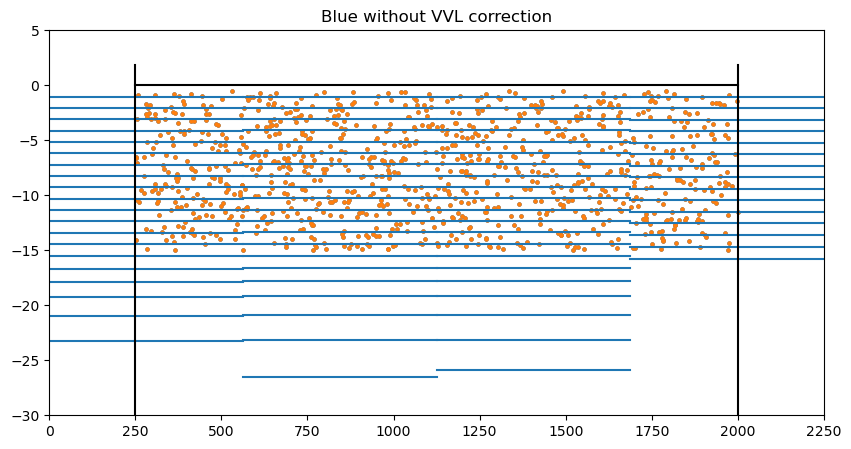

In [19]:
ss =[]
ani = anim2(dat,dat2,dat3,fps=1)
f = r"/home/jvalenti/MOAD/animations/box.gif" 
FFwriter = animation.FFMpegWriter()
ani.save(f, writer = FFwriter)

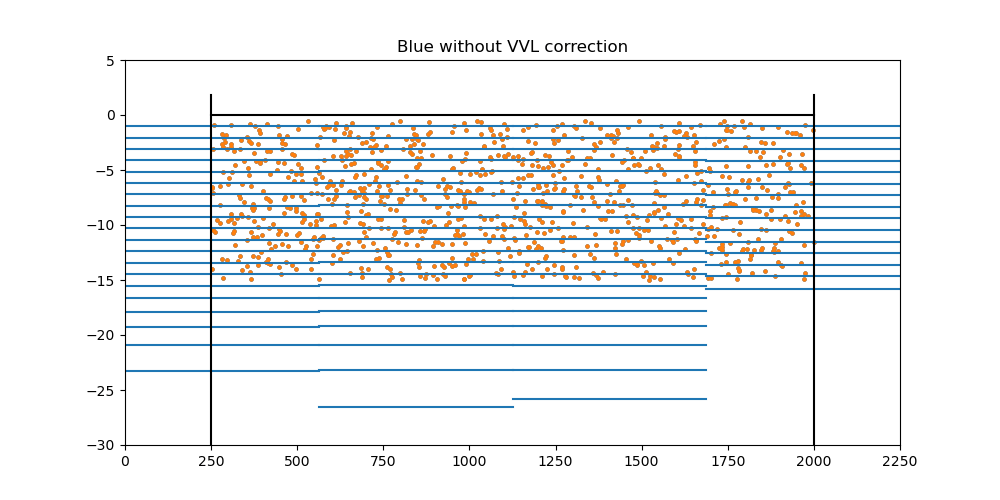

In [20]:
from IPython.display import Image
with open(f,'rb') as anim:
     display(Image(anim.read()))